In [101]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import TimeSeriesSplit
import pickle
import scipy.stats as stats
from scipy.stats import boxcox

In [102]:
files.upload()

Saving kaggle (1).json to kaggle (1) (3).json


{'kaggle (1) (3).json': b'{"username":"mohammedkhattabi","key":"ed9815a90ade7bc05509779b49a85d37"}'}

In [104]:
df = pd.read_csv("Google_Stock_Price.csv")


In [105]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1278 entries, 0 to 1277
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1278 non-null   object 
 1   Open    1278 non-null   float64
 2   High    1278 non-null   float64
 3   Low     1278 non-null   float64
 4   Close   1278 non-null   object 
 5   Volume  1278 non-null   object 
dtypes: float64(3), object(3)
memory usage: 60.0+ KB


In [107]:
dataset = df[['Date', 'Close']]
len(dataset)

1278

In [108]:
dataset=dataset.set_index('Date')
dataset

,Close
Date,
1/3/2012,663.59
1/4/2012,666.45
1/5/2012,657.21
1/6/2012,648.24
1/9/2012,620.76
...,...
1/25/2017,835.67
1/26/2017,832.15
1/27/2017,823.31


In [109]:
dataset.isnull().sum()

,0
Close,0


In [125]:
# Supprimer les magnitudes négatives
dataset = dataset[dataset['Close'] >= 0]

In [127]:
# Compter les valeurs négatives
negative_values = dataset[dataset['Close'] < 0]
print(f"Nombre de valeurs négatives dans Close : {len(negative_values)}")

Nombre de valeurs négatives dans Close : 0


In [119]:
# Normalisation des données
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset[['Close']].values)

In [120]:
dataset_scaled

array([[0.23757287],
       [0.24151427],
       [0.22878051],
       ...,
       [0.45768505],
       [0.42875846],
       [0.42113749]])

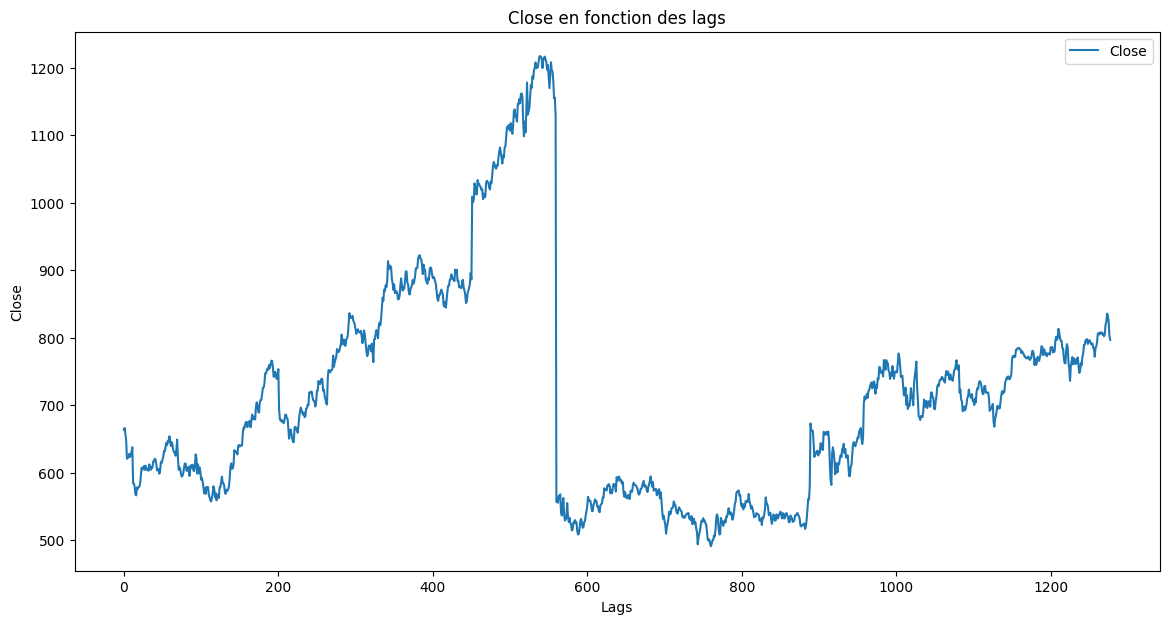

In [121]:
# Création des lags
lags = np.arange(len(dataset))

# Visualisation de la série temporelle avec les lags
plt.figure(figsize=(14, 7))
plt.plot(lags, dataset['Close'], label='Close')
plt.title('Close en fonction des lags')
plt.xlabel('Lags')
plt.ylabel('Close')
plt.legend()
plt.show()

In [128]:
# Création des séquences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [129]:
# Augmentation de données : ajout de bruit
def add_noise(data, noise_level=0.01):
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

In [130]:
# Création des séquences avec données augmentées
seq_length = 60
X, y = create_sequences(dataset_scaled, seq_length)
X_noisy, y_noisy = create_sequences(add_noise(dataset_scaled), seq_length)

In [131]:
# Reshape des données pour LSTM [samples, time steps, features]
X = np.concatenate((X, X_noisy))
y = np.concatenate((y, y_noisy))
# Reshape des données pour LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

In [132]:
# Division en ensembles d'entraînement et de test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [133]:
seq_length = 60
train_size = int(len(X) * 0.8)
lr=0.001
unit=150
dropout=0.4
n_epochs = 100
batch_size = 64

In [134]:
# 2. Construction du modèle LSTM

regressor_lstm = Sequential()

# Première couche LSTM avec Dropout
regressor_lstm.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor_lstm.add(Dropout(dropout))

# Deuxième couche LSTM avec Dropout
regressor_lstm.add(LSTM(units=unit, return_sequences=True))
regressor_lstm.add(Dropout(dropout))

# Troisième couche LSTM avec Dropout
regressor_lstm.add(LSTM(units=unit))
regressor_lstm.add(Dropout(dropout))

# Couche de sortie
regressor_lstm.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [135]:
# Optimiseur avec un taux d'apprentissage plus faible
optimizer = Adam(learning_rate=lr)
regressor_lstm.compile(optimizer=optimizer, loss='mean_squared_error')

In [136]:
# Entraînement du modèle
regressor_lstm.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 492ms/step - loss: 0.0495
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 568ms/step - loss: 0.0080
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 482ms/step - loss: 0.0078
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 18s 396ms/step - loss: 0.0054
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - loss: 0.0078
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - loss: 0.0049
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 386ms/step - loss: 0.0046
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 411ms/step - loss: 0.0042
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - loss: 0.0040
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 398ms/step - loss: 0.0048
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 390ms/step - loss: 0.0038
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 392ms/step - loss: 0.0036
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 397ms/step - loss: 0.0041
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step - loss: 0.0037
Epoch 15/100
31/31 ━━━━━━━━━━

In [137]:
# Sauvegarder le modèle
filename = 'regressor_lstm_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(regressor_lstm, file)

from google.colab import files

# Télécharger le fichier
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load the LSTM model
with open('regressor_lstm_model.pkl', 'rb') as file:
    regressor_lstm = pickle.load(file)

In [138]:
# 4. Prédiction
y_predicted = regressor_lstm.predict(X_test)
y_predicted = scaler.inverse_transform(y_predicted)  # Transformation inverse pour obtenir les valeurs réelles
y_real = scaler.inverse_transform(y_test.reshape(-1, 1))  # Transformation inverse pour les valeurs réelles

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step


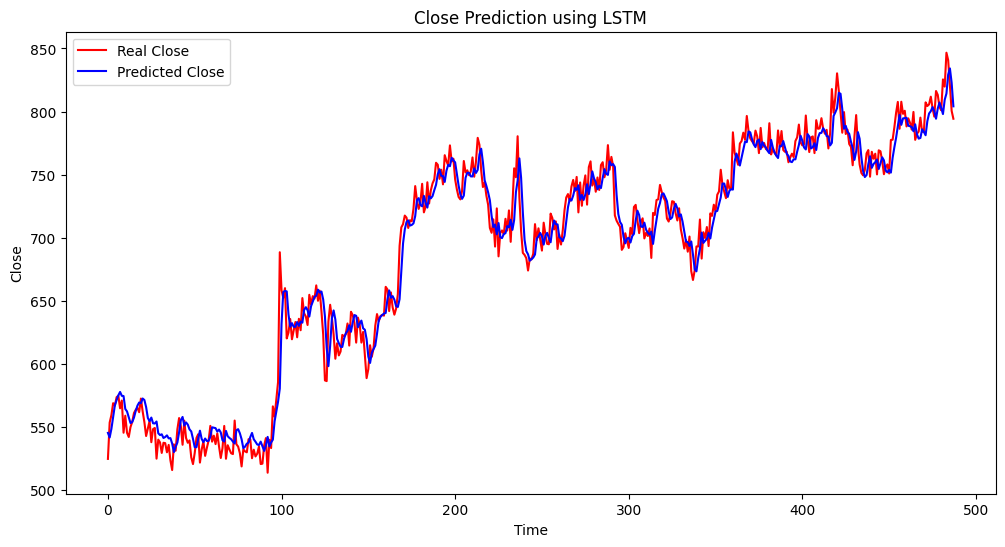

In [139]:
# 5. Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(y_real, color='red', label='Real Close')
plt.plot(y_predicted, color='blue', label='Predicted Close')
plt.title('Close Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

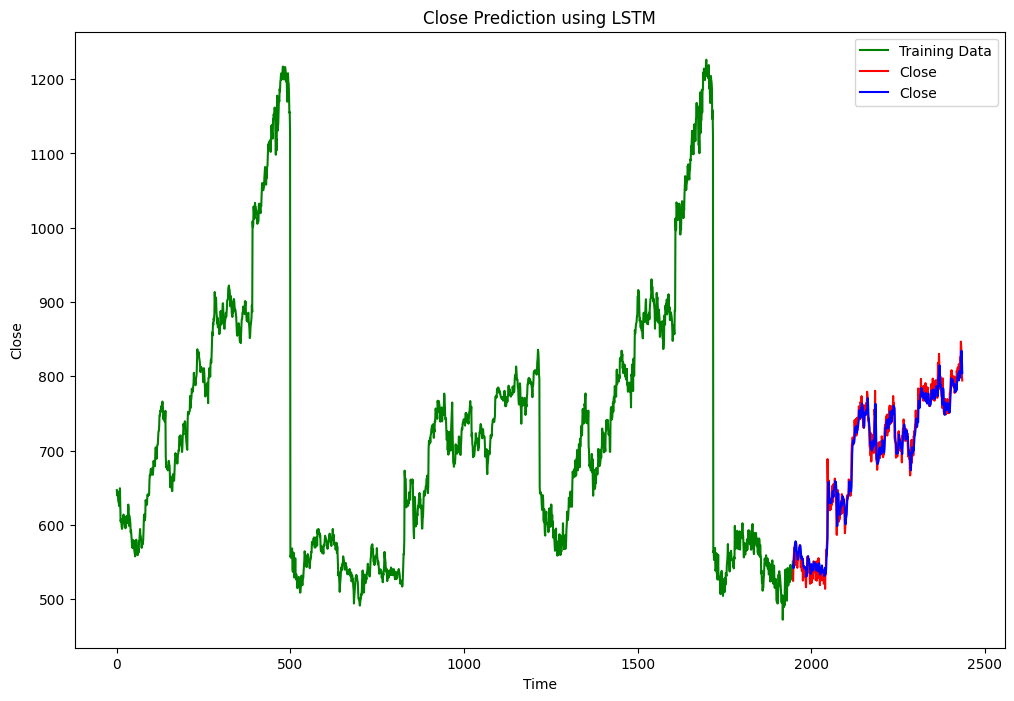

In [140]:
# 6. Visualisation de l'entraînement, des prédictions et des tests
train_range = range(len(y_train))
test_range = range(len(y_train), len(y_train) + len(y_real))
pred_range = range(len(y_train), len(y_train) + len(y_predicted))

plt.figure(figsize=(12, 8))
plt.plot(train_range, scaler.inverse_transform(y_train.reshape(-1, 1)), color='green', label='Training Data')
plt.plot(test_range, y_real, color='red', label='Close')
plt.plot(pred_range, y_predicted, color='blue', label='Close')
plt.title('Close Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()

In [141]:
# 7. Évaluation du modèle
print("Evaluation du modèle:")
mse_lstm = mean_squared_error(y_real, y_predicted)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_real, y_predicted)
r2_lstm = r2_score(y_real, y_predicted)

print(f"Mean Squared Error (MSE): {mse_lstm}")
print(f"Mean Absolute Error (MAE): {mae_lstm}")
print(f"R² Score: {r2_lstm}")

Evaluation du modèle:
Mean Squared Error (MSE): 215.88527344584648
Mean Absolute Error (MAE): 10.969276305178376
R² Score: 0.9731742888174753
